In [1]:
import torch
import torch.nn as nn
import spconv.pytorch as spconv
from SparseVoxelShuffle import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Generate Sparse Tensor

In [2]:
# Function to generate random input indices
def generate_custom_tensor(rows, cols, max_value):
    # Directly generate the full tensor with random integers.
    # First column will be zeroed out to mimic the original logic (if needed).
    tensor = torch.randint(0, max_value + 1, (rows, cols), dtype=torch.int32)
    tensor[:, 0] = 0  # Set the first column to zero if that's a required feature.
    return tensor

def generate_unique_custom_tensors(data_size, cols, max_value):
    seen = set()
    tensors = []
    while len(tensors) < data_size:
        tensor = generate_custom_tensor(1, cols, max_value)
        # Convert tensor to a tuple of tuples for faster comparison and hashable type.
        tensor_tuple = tuple(map(tuple, tensor.tolist()))
        if tensor_tuple not in seen:
            seen.add(tensor_tuple)
            tensors.append(tensor)
    # Concatenate tensors and transfer to CUDA in one operation.
    result = torch.cat(tensors).int()
    if torch.cuda.is_available():
        result = result.cuda()
    return result


In [3]:
# Create a SparseConvTensor
features = torch.randn(3, 16).to(device)  # Example features
indices = generate_unique_custom_tensors(3, 4, 1).to(device)

print(features.shape)
print(indices.shape)

spatial_shape = [2, 2, 2]
batch_size = 1
sparse_tensor = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

torch.Size([3, 16])
torch.Size([3, 4])


### Basic Operation

In [4]:
pairing_style='sequential'
voxel_shuffle = VoxelShuffle(upscale_factor=2, pairing_style=pairing_style, layout_style='yzx').to(device)
voxel_unshuffle = VoxelUnshuffle(scale=2, pairing_style=pairing_style).to(device)
print("Before:")
print(sparse_tensor.indices)
print(sparse_tensor.features)

output_0, vs_dict = voxel_shuffle(sparse_tensor)
print("After VS:")
print(output_0.indices)
print(output_0.features)

output_1 = voxel_unshuffle(output_0, vs_dict)
print("After UnVS:")
print(output_1.indices)
print(output_1.features)

assert(torch.equal(sparse_tensor.indices.to('cpu'), output_1.indices.to('cpu')))
assert(torch.equal(sparse_tensor.features.to('cpu'), output_1.features.to('cpu')))


Before:
tensor([[0, 0, 0, 1],
        [0, 1, 0, 1],
        [0, 0, 1, 0]], device='cuda:0', dtype=torch.int32)
tensor([[-0.5089,  1.9371, -0.1935,  0.2218, -0.2166,  2.3778, -0.0535,  1.0568,
         -0.2455, -1.0209,  0.6937, -1.2022,  0.6098, -0.6827, -0.2057, -0.1883],
        [ 0.0232, -0.7271,  0.0422,  1.1850, -1.8519, -0.2526,  0.8492, -0.3155,
          0.7648, -0.0572, -0.4028, -1.3966, -0.5427,  2.6835,  0.1862, -0.4766],
        [ 0.7007,  0.4797, -1.1595, -1.0384, -1.7415, -1.0407, -1.2544, -0.8492,
          0.3992,  0.4830,  0.2047, -1.0923, -0.7747,  0.3648,  1.3893, -0.6438]],
       device='cuda:0')
After VS:
tensor([[0, 0, 0, 2],
        [0, 1, 0, 2],
        [0, 0, 0, 3],
        [0, 1, 0, 3],
        [0, 0, 1, 2],
        [0, 1, 1, 2],
        [0, 0, 1, 3],
        [0, 1, 1, 3],
        [0, 2, 0, 2],
        [0, 3, 0, 2],
        [0, 2, 0, 3],
        [0, 3, 0, 3],
        [0, 2, 1, 2],
        [0, 3, 1, 2],
        [0, 2, 1, 3],
        [0, 3, 1, 3],
        [0, 0

### Visualization

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# Function to plot a single voxel
def plot_voxel(x, y, z, ax, color='r'):
    # Define the vertices of the voxel
    vertices = [[x, y, z],
                [x + 1, y, z],
                [x + 1, y + 1, z],
                [x, y + 1, z],
                [x, y, z + 1],
                [x + 1, y, z + 1],
                [x + 1, y + 1, z + 1],
                [x, y + 1, z + 1]]

    # Define the 6 faces of the voxel
    faces = [[vertices[j] for j in [0, 1, 5, 4]],
             [vertices[j] for j in [7, 6, 2, 3]],
             [vertices[j] for j in [0, 3, 7, 4]],
             [vertices[j] for j in [1, 2, 6, 5]],
             [vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]]]

    poly3d = [[tuple(vertex) for vertex in face] for face in faces]
    collection = Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5)
    ax.add_collection3d(collection)


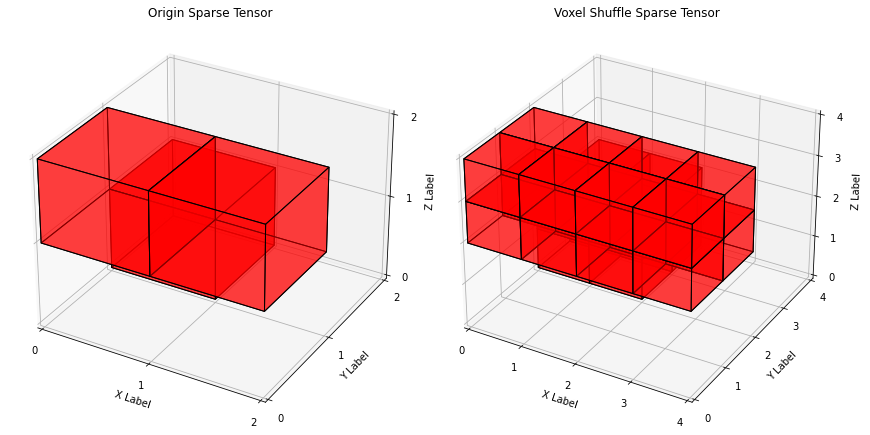

In [6]:
# Create a figure
fig = plt.figure(figsize=(12, 6))

# First subplot for the original sparse tensor
ax1 = fig.add_subplot(121, projection='3d')
coords1 = indices[:, 1:].cpu().numpy()  # Original tensor coordinates
for coord in coords1:
    plot_voxel(coord[0], coord[1], coord[2], ax1)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Origin Sparse Tensor')
ax1.set_xlim([0, 2])
ax1.set_ylim([0, 2])
ax1.set_zlim([0, 2])
ax1.set_xticks(np.arange(0, 3, 1))
ax1.set_yticks(np.arange(0, 3, 1))
ax1.set_zticks(np.arange(0, 3, 1))

# Second subplot for the voxel shuffle sparse tensor
ax2 = fig.add_subplot(122, projection='3d')
coords2 = output_0.indices[:, 1:].cpu().numpy()  # Voxel shuffled tensor coordinates
for coord in coords2:
    plot_voxel(coord[0], coord[1], coord[2], ax2)
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('Voxel Shuffle Sparse Tensor')
ax2.set_xlim([0, 4])
ax2.set_ylim([0, 4])
ax2.set_zlim([0, 4])
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_yticks(np.arange(0, 5, 1))
ax2.set_zticks(np.arange(0, 5, 1))

# Show the plot
plt.tight_layout()
plt.show()

### Operation For Upsample

In [3]:
from SparseVoxelShuffleUtils import VoxelUnshuffleInvConv3D

# Create a new SparseConvTensor
features = torch.randn(512, 16).to(device)  # Example features
indices = generate_unique_custom_tensors(512, 4, 16).to(device)

spatial_shape = [16, 16, 16]
batch_size = 1
sparse_tensor_0 = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [4]:
print(f"Input Indice Shape: \nIndice:{sparse_tensor_0.indices.shape} Features: {sparse_tensor_0.features.shape}")
print(f"Indice:\n{sparse_tensor_0.indices}\nFeatures:\n{sparse_tensor_0.features}")

Input Indice Shape: 
Indice:torch.Size([512, 4]) Features: torch.Size([512, 16])
Indice:
tensor([[ 0,  5,  3, 12],
        [ 0,  3, 11, 16],
        [ 0, 14,  1,  1],
        ...,
        [ 0,  6,  0,  1],
        [ 0,  2, 10,  9],
        [ 0, 15, 11,  6]], device='cuda:0', dtype=torch.int32)
Features:
tensor([[ 1.1946e+00,  5.2022e-01, -1.5676e+00,  ..., -5.3675e-01,
         -1.2460e-02,  1.1605e+00],
        [-2.9149e-01, -1.6718e-01, -6.9926e-01,  ...,  1.2577e+00,
         -1.5576e+00,  7.0901e-01],
        [-2.3681e+00,  2.3620e+00, -1.0689e-01,  ...,  1.0777e+00,
          3.3554e-02, -3.8082e-01],
        ...,
        [-9.6882e-01,  1.1297e+00,  6.6706e-01,  ...,  8.9884e-01,
          7.6883e-01, -2.9809e-01],
        [ 6.8241e-01, -5.0127e-02,  9.2314e-01,  ..., -1.1537e+00,
         -2.8857e-01, -1.4320e+00],
        [ 1.1234e+00, -7.4947e-01, -1.0082e+00,  ...,  5.9376e-01,
          6.0243e-01,  2.1835e-03]], device='cuda:0')


In [5]:
class ExampleNetUsingInvConv(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.net = spconv.SparseSequential(
            spconv.SparseConv3d(16, 32, 2, 2, indice_key="cp0"),
            spconv.SparseInverseConv3d(32, 16, 2, indice_key="cp0"), # need provide kernel size to create weight
        )
        self.shape = shape

    def forward(self, features, coors, batch_size):
        coors = coors.int()
        x = spconv.SparseConvTensor(features, coors, self.shape, batch_size)
        return self.net(x)

In [6]:
example_net = ExampleNetUsingInvConv((32,32,32)).to(device)
out_tensor = example_net(features, indices, 1)

In [7]:
print(f"Output Indice Shape: \nIndice:{out_tensor.indices.shape} Features: {out_tensor.features.shape}")
print(f"Indice:\n{out_tensor.indices}\nFeatures:\n{out_tensor.features}")

Output Indice Shape: 
Indice:torch.Size([512, 4]) Features: torch.Size([512, 16])
Indice:
tensor([[ 0,  5,  3, 12],
        [ 0,  3, 11, 16],
        [ 0, 14,  1,  1],
        ...,
        [ 0,  6,  0,  1],
        [ 0,  2, 10,  9],
        [ 0, 15, 11,  6]], device='cuda:0', dtype=torch.int32)
Features:
tensor([[ 0.0575, -0.0368,  0.0710,  ...,  0.0456,  0.0071,  0.0476],
        [ 0.0899, -0.1198, -0.0098,  ..., -0.0741,  0.1511,  0.0044],
        [ 0.0668, -0.2161, -0.0151,  ...,  0.0910,  0.0663,  0.0723],
        ...,
        [ 0.0294, -0.0005,  0.0555,  ..., -0.0601,  0.0869,  0.1067],
        [ 0.1342, -0.0479,  0.0007,  ...,  0.0591,  0.0928,  0.0695],
        [ 0.0580, -0.1138, -0.0924,  ..., -0.1073,  0.1115, -0.0067]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [8]:
class ExampleNetUsingShuffleConv(nn.Module):
    def __init__(self, shape):
        super().__init__()
        in_channels = 32
        out_channels = 16
        scale = 2
        pairing_style = 'sequential'
        layout_style = 'xyz'
        indice_key = 'cp0'
        
        self.spconv = spconv.SparseConv3d(16, 32, 2, 2, indice_key=indice_key)
        self.inconv = VoxelUnshuffleInvConv3D(in_channels, out_channels, scale, pairing_style, layout_style, indice_key)
        self.shape = shape

    def forward(self, features, coors, batch_size):
        coors = coors.int()
        x = spconv.SparseConvTensor(features, coors, self.shape, batch_size)
        x = self.spconv(x)        
        x = self.inconv(x)
        return x

In [9]:
example_net_1 = ExampleNetUsingShuffleConv((32,32,32)).to(device)
out_tensor_1 = example_net_1(features, indices, 1)

In [10]:
print(f"Output Indice Shape: \nIndice:{out_tensor_1.indices.shape} Features: {out_tensor_1.features.shape}")
print(f"Indice:\n{out_tensor_1.indices}\nFeatures:\n{out_tensor_1.features}")

Output Indice Shape: 
Indice:torch.Size([512, 4]) Features: torch.Size([512, 16])
Indice:
tensor([[ 0,  5,  3, 12],
        [ 0,  3, 11, 16],
        [ 0, 14,  1,  1],
        ...,
        [ 0,  6,  0,  1],
        [ 0,  2, 10,  9],
        [ 0, 15, 11,  6]], device='cuda:0', dtype=torch.int32)
Features:
tensor([[ 0.0608, -0.3729,  0.2238,  ..., -0.4661, -0.4314, -0.9380],
        [-1.1551,  2.8381,  0.0951,  ..., -1.9031,  1.3542, -1.9913],
        [-2.6914,  1.4889,  0.2004,  ..., -2.0409,  0.2375, -0.8883],
        ...,
        [-1.4993,  1.9846, -0.9811,  ...,  0.0335, -0.3435,  2.0094],
        [-0.8187, -0.1464, -0.7793,  ..., -1.0272, -1.8111,  2.8589],
        [-1.4457,  0.1703, -2.1423,  ...,  1.1798, -0.1528, -2.6678]],
       grad_fn=<CopySlices>)
